
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Simulate Monthly Mean Sea Level using a multivariate-linear regression model based on the annual SST PCs

inputs required: 
  * WaterLevel historical data from a tide gauge at the study site 
  * Historical and simulated Annual PCs (*from Notebook 01*)

in this notebook:
  * Obtain monthly mean sea level anomalies (MMSLA) from the tidal gauge record
  * Perform linear regression between MMSLA and annual PCs
  * Obtain predicted timeseries of MMSLA based on simulated timeseries of annual PCs 

### Workflow:

<div>
<img src="resources/nb01_02.png" width="300px">
</div>



Monthly sea level variability is typically due to processes occurring at longer timescales than the daily weather. Slowly varying seasonality and anomalies due to ENSO are retained in the climate emulator via the principle components (APC) used to develop the AWT. A multivariate regression model containing a mean plus annual and seasonal cycles at 12-month and 6-month periods for each APC covariate was fit to the MMSLA. This simple model explains ~75% of the variance without any specific information regarding local conditions (i.e., local anomalies due to coastal shelf dynamics, or local SSTAs) and slightly underpredicts extreme monthly sea level anomalies by ~10 cm. While this component of the approach is a subject of ongoing research, the regression model produces an additional ~0.35 m of regional SWL variability about mean sea level, which was deemed sufficient for the purposes of demonstrating the development of the stochastic climate emulator.

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
from collections import OrderedDict

# python libs
import numpy as np
from numpy.random import multivariate_normal
import xarray as xr
from scipy.stats import linregress
from scipy.optimize import least_squares, curve_fit
from datetime import datetime, timedelta

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.tides import Calculate_MMSL
from teslakit.statistical import runmean
from teslakit.util.time_operations import date2yearfrac as d2yf

from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL, \
Plot_Validate_MMSL_tseries, Plot_Validate_MMSL_scatter, Plot_MMSL_Prediction, \
Plot_MMSL_Histogram



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


In [3]:
# --------------------------------------
# load data and set parameters

WL_gauge, WL_split = db.Load_TIDE_hist()      # water level historical data (tide gauge)
WL = WL_split.WaterLevels

SST_KMA = db.Load_SST_KMA()              # SST Anual Weather Types PCs
SST_PCs_sim_m = db.Load_SST_PCs_sim_m()  # simulated SST PCs (monthly)

# parameters for mmsl calculation
mmsl_year_ini = 1947
mmsl_year_end = 2018



## Monthly Mean Sea Level

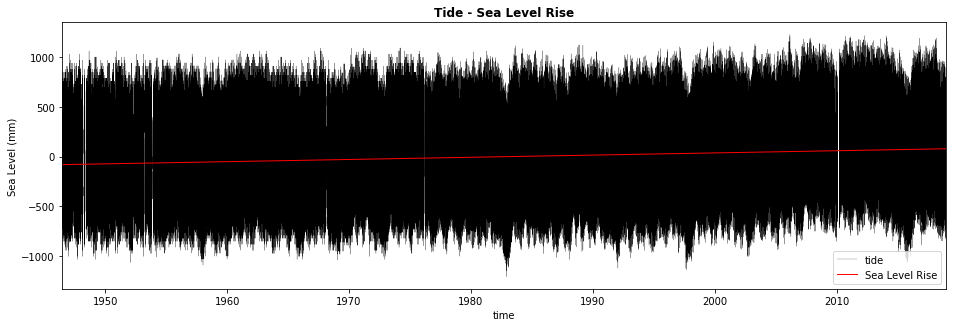

In [4]:
# --------------------------------------
# Calculate SLR using linear regression

time = WL.time.values[:]
wl = WL.values[:] * 1000  # (m to mm)

lr_time = np.array(range(len(time)))  # for linregress
mask = ~np.isnan(wl)  # remove nans with mask

slope, intercept, r_value, p_value, std_err = linregress(lr_time[mask], wl[mask])
slr = intercept + slope * lr_time

# Plot tide with SLR
Plot_Tide_SLR(time, wl, slr);


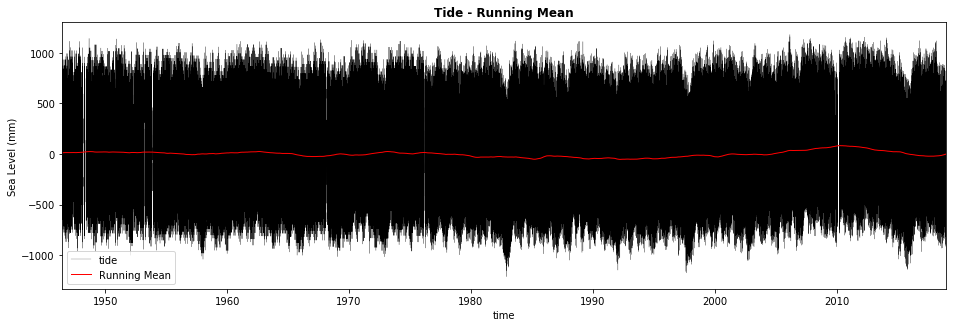

In [5]:
# --------------------------------------
# remove SLR and runmean from tide 

tide_noslr = wl - slr

# calculate tide running mean
time_window = 365*24*3
runm = runmean(tide_noslr, time_window, 'mean')

# remove running mean
tide_noslr_norunm = tide_noslr - runm

# store data 
TNSR = xr.DataArray(tide_noslr_norunm,  dims=('time'), coords={'time':time})


# Plot tide without SLR and runm
Plot_Tide_RUNM(time, tide_noslr, runm);


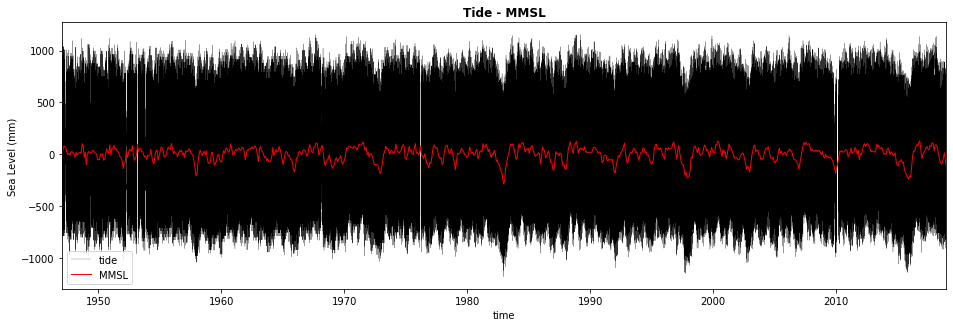

In [6]:
# --------------------------------------
# calculate Monthly Mean Sea Level (mmsl)

MMSL = Calculate_MMSL(TNSR, mmsl_year_ini, mmsl_year_end)

# fill nans with interpolated values
p_nan = np.isnan(MMSL.mmsl)
MMSL.mmsl[p_nan]= np.interp(MMSL.time[p_nan], MMSL.time[~p_nan], MMSL.mmsl[~p_nan])

mmsl_time = MMSL.time.values[:]
mmsl_vals = MMSL.mmsl.values[:]

# Plot tide and mmsl 
Plot_Tide_MMSL(TNSR.time, TNSR.values, mmsl_time, mmsl_vals);

# store historical mmsl
db.Save_TIDE_hist_mmsl(MMSL)



## Monthly Mean Sea Level - Principal Components
The annual PCs are passed to a monthly resolution

In [7]:
# --------------------------------------
# SST Anual Weather Types PCs

PCs = np.array(SST_KMA.PCs.values)
PC1, PC2, PC3 = PCs[:,0], PCs[:,1], PCs[:,2]
PCs_years = [int(str(t).split('-')[0]) for t in SST_KMA.time.values[:]]

# MMSL PCs calculations: cut and pad it to monthly resolution
ntrs_m_mean = np.array([])
ntrs_time = []

MMSL_PC1 = np.array([])
MMSL_PC2 = np.array([])
MMSL_PC3 = np.array([])

for c, y in enumerate(PCs_years):
    pos = np.where(
        (mmsl_time >= np.datetime64('{0}-06-01'.format(y))) &
        (mmsl_time <= np.datetime64('{0}-05-29'.format(y+1)))
    )

    if pos[0].size:
        ntrs_m_mean = np.concatenate((ntrs_m_mean, mmsl_vals[pos]),axis=0)
        # TODO check for 0s and nans in ntrs_m_mean?
        ntrs_time.append(mmsl_time[pos])

        MMSL_PC1 = np.concatenate((MMSL_PC1, np.ones(pos[0].size)*PC1[c]),axis=0)
        MMSL_PC2 = np.concatenate((MMSL_PC2, np.ones(pos[0].size)*PC2[c]),axis=0)
        MMSL_PC3 = np.concatenate((MMSL_PC3, np.ones(pos[0].size)*PC3[c]),axis=0)

ntrs_time = np.concatenate(ntrs_time)

# Parse time to year fraction for linear-regression seasonality 
frac_year = np.array([d2yf(x) for x in ntrs_time])



## Monthly Mean Sea Level - Multivariate-linear Regression Model

In [8]:
# --------------------------------------
# Fit linear regression model 

def modelfun(data, *x):
    pc1, pc2, pc3, t = data
    
    return x[0] + x[1]*pc1 + x[2]*pc2 + x[3]*pc3 + \
            np.array([x[4] + x[5]*pc1 + x[6]*pc2 + x[7]*pc3]).flatten() * np.cos(2*np.pi*t) + \
            np.array([x[8] + x[9]*pc1 + x[10]*pc2 + x[11]*pc3]).flatten() * np.sin(2*np.pi*t) + \
            np.array([x[12] + x[13]*pc1 + x[14]*pc2 + x[15]*pc3]).flatten() * np.cos(4*np.pi*t) + \
            np.array([x[16] + x[17]*pc1 + x[18]*pc2 + x[19]*pc3]).flatten() * np.sin(4*np.pi*t)

# use non-linear least squares to fit our model
split = 160  # train / validation split index
x0 = np.ones(20)
sigma = np.ones(split)

# select data for scipy.optimize.curve_fit
x_train = ([MMSL_PC1[:split], MMSL_PC2[:split], MMSL_PC3[:split], frac_year[:split]])
y_train = ntrs_m_mean[:split]

res_lsq, res_cov = curve_fit(modelfun, x_train, y_train, x0, sigma)

# print optimal parameters and covariance
#print('optimal parameters (minimized sum of squares residual)\n{0}\n'.format(res_lsq))
#print('optimal parameters covariance\n{0}\n'.format(res_cov))


## Train and test model

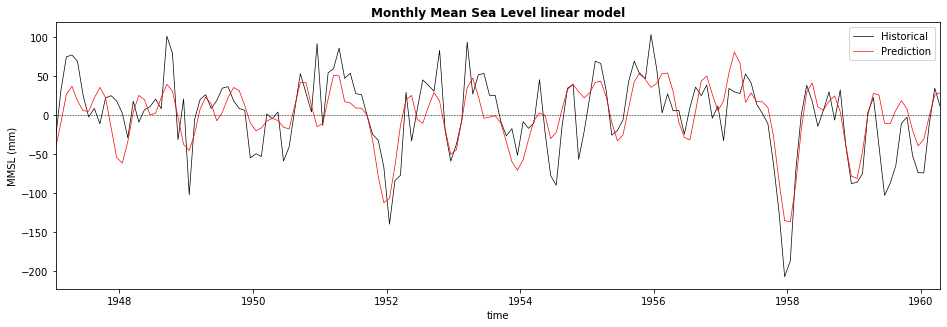

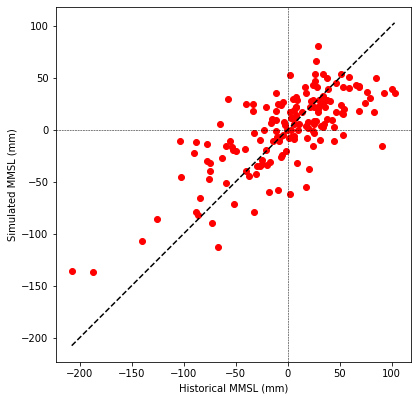

In [9]:
# Check model at fitting period

yp_train = modelfun(x_train, *res_lsq)

Plot_Validate_MMSL_tseries(ntrs_time[:split], ntrs_m_mean[:split], yp_train);
Plot_Validate_MMSL_scatter(ntrs_m_mean[:split], yp_train);


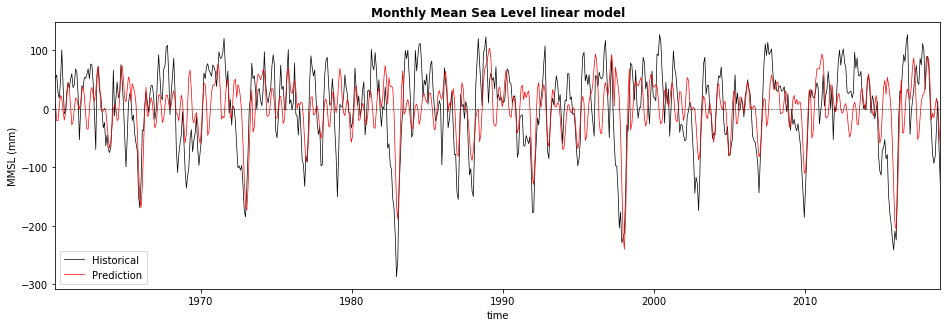

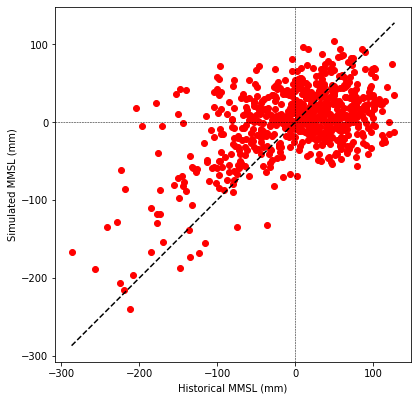

In [10]:
# Check model at validation period

x_val = ([MMSL_PC1[split:], MMSL_PC2[split:], MMSL_PC3[split:], frac_year[split:]])
yp_val = modelfun(x_val, *res_lsq)

Plot_Validate_MMSL_tseries(ntrs_time[split:], ntrs_m_mean[split:], yp_val);
Plot_Validate_MMSL_scatter(ntrs_m_mean[split:], yp_val);


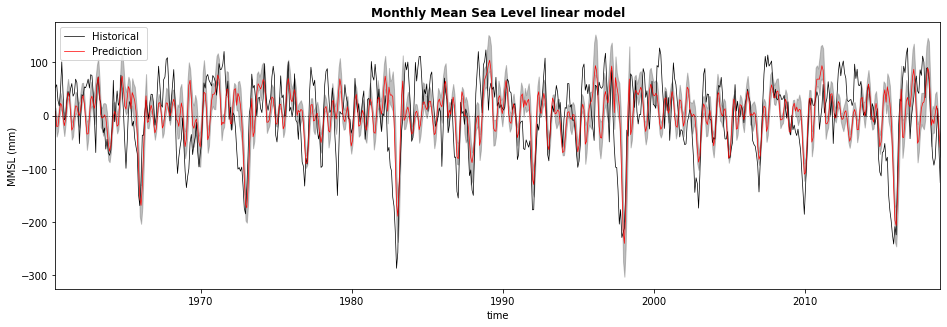

In [11]:
# Parameter sampling (generate sample of params based on covariance matrix)

n_sims = 10
theta_gen = res_lsq
theta_sim = multivariate_normal(theta_gen, res_cov, n_sims)


# Check model at validation period
yp_valp = np.ndarray((n_sims, len(ntrs_time[split:]))) * np.nan
for i in range(n_sims):
    yp_valp[i, :] = modelfun(x_val, *theta_sim[i,:])

# 95% percentile
yp_val_quant = np.percentile(yp_valp, [2.275, 97.275], axis=0)

Plot_Validate_MMSL_tseries(ntrs_time[split:], ntrs_m_mean[split:], yp_val, mmsl_pred_quantiles=yp_val_quant);


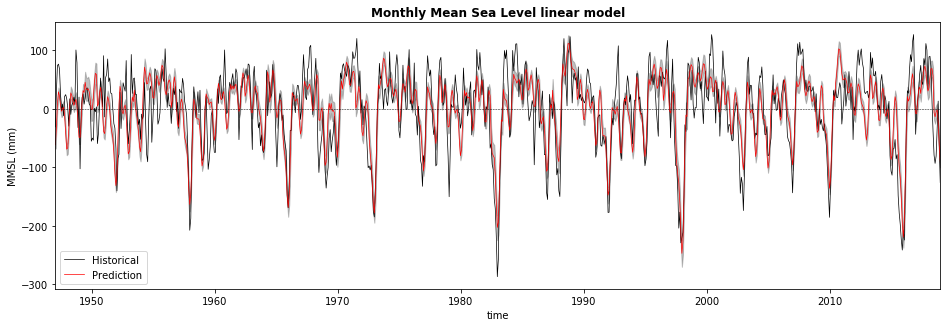

In [12]:
# Fit model using entire dataset

sigma = np.ones(len(frac_year))
x_fit = ([MMSL_PC1, MMSL_PC2, MMSL_PC3, frac_year])
y_fit = ntrs_m_mean

res_lsq, res_cov = curve_fit(modelfun, x_fit, y_fit, x0, sigma)

# obtain model output
yp = modelfun(x_fit, *res_lsq)


# Generate 1000 simulations of the parameters 
n_sims = 1000
theta_gen = res_lsq
param_sim = multivariate_normal(theta_gen, res_cov, n_sims)


# Check model
yp_p = np.ndarray((n_sims, len(ntrs_time))) * np.nan
for i in range(n_sims):
    yp_p[i, :] = modelfun(x_fit, *param_sim[i,:])

# 95% percentile
yp_quant = np.percentile(yp_p, [2.275, 97.275], axis=0)

Plot_Validate_MMSL_tseries(ntrs_time, ntrs_m_mean, yp, mmsl_pred_quantiles=yp_quant);




## Monthly Mean Sea Level - Prediction

In [13]:
# --------------------------------------
# Predict 1000 years using simulated PCs (monthly time resolution)

# get simulation time as year fractions
PCs_sim_time = SST_PCs_sim_m.time.values[:]
frac_year_sim = np.array([d2yf(x) for x in PCs_sim_time])

# solve each PCs simulation
y_sim_n = np.ndarray((len(SST_PCs_sim_m.n_sim), len(frac_year_sim))) * np.nan
for s in SST_PCs_sim_m.n_sim:
    
    PCs_s_m = SST_PCs_sim_m.sel(n_sim=s)
    MMSL_PC1_sim = PCs_s_m.PC1.values[:]
    MMSL_PC2_sim = PCs_s_m.PC2.values[:]
    MMSL_PC3_sim = PCs_s_m.PC3.values[:]
    
    # use linear-regression model
    x_sim = ([MMSL_PC1_sim, MMSL_PC2_sim, MMSL_PC3_sim, frac_year_sim])
    y_sim_n[s, :] = modelfun(x_sim, *param_sim[s,:])


# join output and store it
MMSL_sim = xr.Dataset(
    {
        'mmsl' : (('n_sim','time'), y_sim_n / 1000),  # mm to m
    },
    {'time' : PCs_sim_time}
)
print(MMSL_sim)

db.Save_TIDE_sim_mmsl(MMSL_sim)


<xarray.Dataset>
Dimensions:  (n_sim: 100, time: 12012)
Coordinates:
  * time     (time) object 1999-06-01 00:00:00 ... 3000-05-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    mmsl     (n_sim, time) float64 0.04537 0.04647 0.06725 ... 0.03452 0.0418


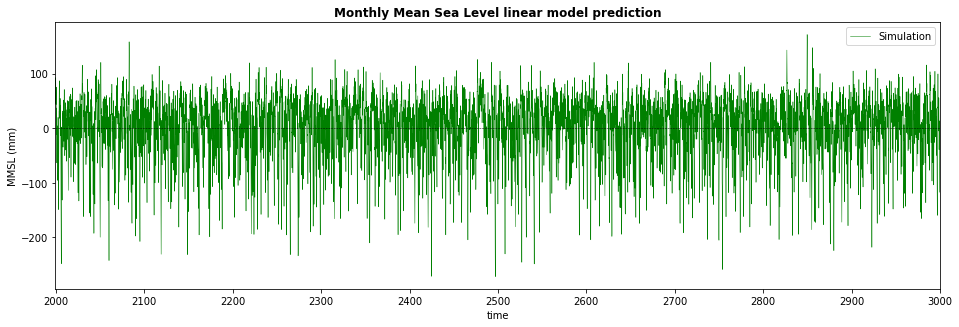

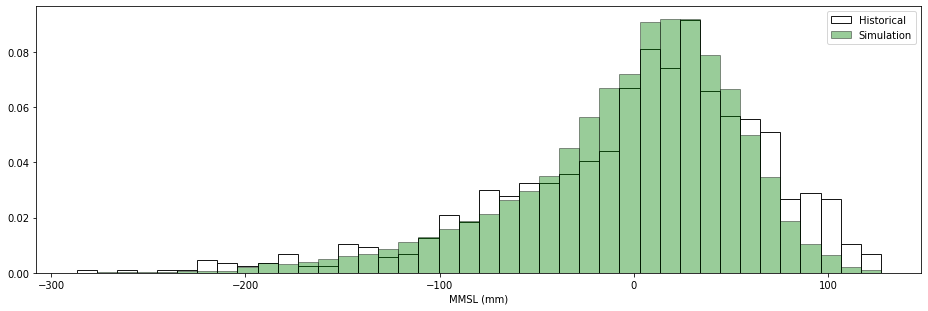

In [14]:
# Plot mmsl simulation 

plot_sim = 0

y_sim = MMSL_sim.sel(n_sim=plot_sim).mmsl.values[:] * 1000  # m to mm
t_sim = MMSL_sim.sel(n_sim=plot_sim).time.values[:]

# Plot mmsl prediction
Plot_MMSL_Prediction(t_sim, y_sim);

# compare model histograms
Plot_MMSL_Histogram(ntrs_m_mean, y_sim);


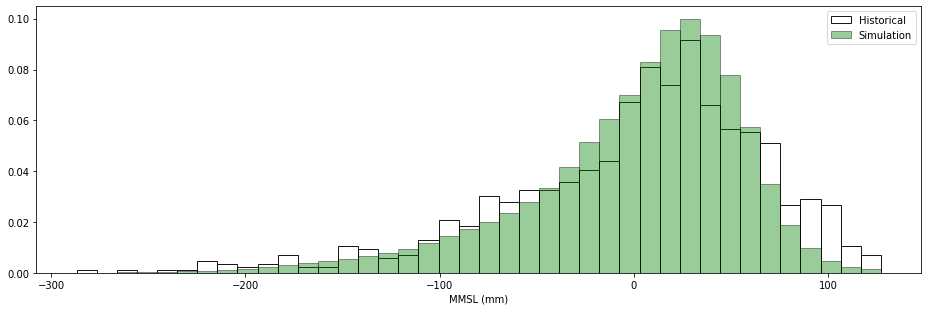

In [15]:
# compare model histograms for all simulations

y_sim = MMSL_sim.mmsl.values[:].flatten() * 1000  # m to mm

Plot_MMSL_Histogram(ntrs_m_mean, y_sim);
